In [1]:
using JLD

push!(LOAD_PATH, ".")
using Util


function policy2name(tree_policy)
    
    scale_str = ""
    if haskey(tree_policy, "bScale") && tree_policy["bScale"] == true
        scale_str = "s"
    end
    
    if tree_policy["type"] == :UCB1
        if haskey(tree_policy, "c")
            return string(tree_policy["type"]) * scale_str * "(" * string(tree_policy["c"]) * ")"
        else
            return string(tree_policy["type"]) * scale_str
        end
    elseif tree_policy["type"] == :TS || tree_policy["type"] == :TSM
        return string(tree_policy["type"])
    elseif tree_policy["type"] == :AUCB
        sp = ""
        for i = 1:length(tree_policy["SP"])
            sp *= policy2name(tree_policy["SP"][i])
            if i != length(tree_policy["SP"])
                sp *= ","
            end
        end
        #return "A-UCB" * scale_str * "(" * sp * ")"
        return "A-UCB" * scale_str
    end
end


function processDataByScenario(datafile::ASCIIString; datadir::ASCIIString = ".")
    
    D = load(joinpath(datadir, datafile));
    
    Scenarios = D["Scenarios"]
    TreePolicies = D["TreePolicies"]
    Results = D["Results"]
    
    R = Dict()
    
    for (key, results) in Results
        scenario, tree_policy = key
        expected_returns = results["expected_returns"]
        if !haskey(R, scenario)
            R[scenario] = Dict()
        end
        R[scenario]["optimum"] = results["opt_dist"]
        tpn = policy2name(tree_policy)
        R[scenario][tpn] = Dict()
        R[scenario][tpn]["mean"] = mean(expected_returns)
        R[scenario][tpn]["std"] = std(expected_returns)
    end

    for scenario in Scenarios
        R_ = R[scenario]
        println("Scenario: ", scenario, ", Optimum: ", neat(R_["optimum"]))
        for tree_policy in TreePolicies[scenario]
            tpn = policy2name(tree_policy)
            println("  policy: ", @sprintf("%-34s", tpn), ", mean: ", @sprintf("%7s", neat(R_[tpn]["mean"])), ", std: ", @sprintf("%6.2f", neat(R_[tpn]["std"])))
        end
        println()
    end
end


function processDataByTreePolicy(n_list::Vector{Int64}; datadir::ASCIIString = ".")

    D = load(joinpath(datadir, "exp_" * string(n_list[1]) * ".jld"));
    TP_list = map(policy2name, D["TreePolicies"][D["Scenarios"][1]])

    C = Dict()
    for tp in TP_list
        C[tp] = Dict()
    end

    for n in n_list
        D = load(joinpath(datadir, "exp_" * string(n) * ".jld"));

        R = Dict()

        for (key, results) in D["Results"]
            scenario, tree_policy = key
            tp = policy2name(tree_policy)

            if !haskey(R, tp)
                R[tp] = Float64[]
            end

            push!(R[tp], mean((results["expected_returns"] - results["opt_dist"]) / results["opt_dist"]))
        end

        for tp in TP_list
            C[tp][n] = Dict()
            C[tp][n]["mean"] = mean(R[tp])
            C[tp][n]["std"] = std(R[tp])
            C[tp][n]["N"] = length(R[tp])
        end
    end

    return C
end

;

In [2]:
using PyPlot


function plotDataByTreePolicy(TP_list::Vector{ASCIIString}, n_list::Vector{Int64}; datadir::ASCIIString = ".", bPlotErrorBar::Bool = true)

    color_list = ["b", "g", "r", "c", "m"]

    D = processDataByTreePolicy(n_list, datadir = datadir)

    i = 1
    for tp in TP_list
        X = Float64[]
        E = Float64[]

        for n in n_list
            push!(X, D[tp][n]["mean"])
            # 95% confidence interval
            push!(E, 1.96 * D[tp][n]["std"] / sqrt(D[tp][n]["N"]))
        end

        semilogx(n_list, X, "x-" * color_list[i], label = tp)
        if bPlotErrorBar
            errorbar(n_list, X, yerr = E, fmt = "x", ecolor = color_list[i])
        end

        i += 1
    end

    xlim(round(Int64, 0.5 * n_list[1]), round(Int64, 2 * n_list[end]))
    xlabel("Number of iterations")
    ylabel("Relative error")
    legend(loc = "best")
end

;

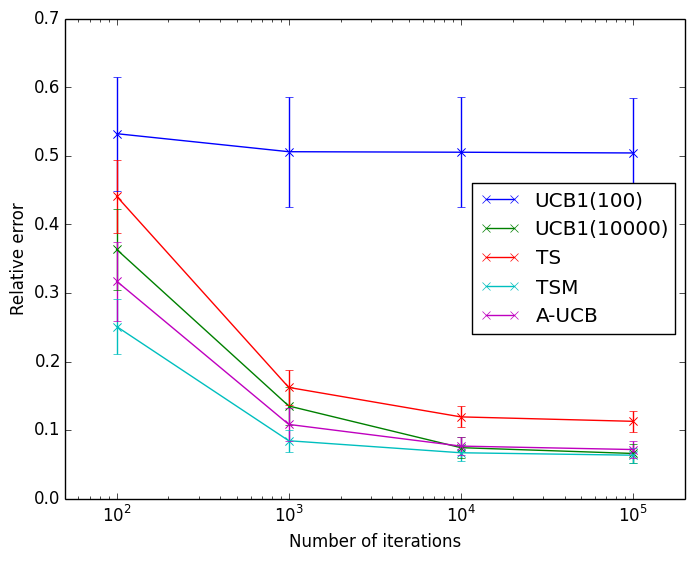

In [3]:
plotDataByTreePolicy(["UCB1(100)", "UCB1(10000)", "TS", "TSM", "A-UCB"], [100, 1000, 10000, 100000], datadir = "data_ijcai_01");

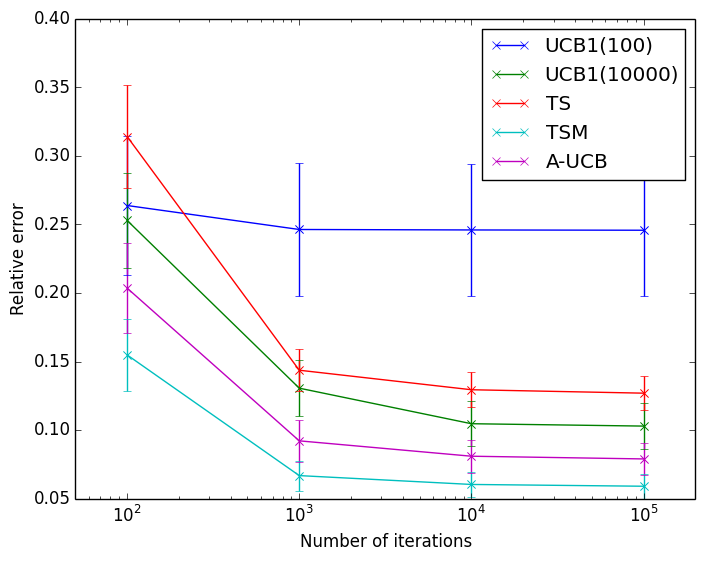

In [4]:
plotDataByTreePolicy(["UCB1(100)", "UCB1(10000)", "TS", "TSM", "A-UCB"], [100, 1000, 10000, 100000], datadir = "data_ijcai_02");